## 0. Import libraries ans set device-agnostic code

In [1]:
import torch
import torchvision
from torch import nn
import gdown
import zipfile
import os
from pathlib import Path
import random
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchinfo
from torchinfo import summary
from tqdm.auto import tqdm
from timeit import default_timer as timer
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

**Note**: I commented unzip code because I dont need always to unzip folder. I need to do this only once. Folder contains all samples from Food101 dataset that are classified as pizza, sushi and steak. I retrieved only 3 classes for easier and quicker classifing images. The model created in this notebook can perform and on whole dataset as well

In [3]:
# Download the dataset from Google Drive
url = 'https://drive.google.com/uc?id=1bMtiiTfZCcVPmsSmJ5nEPzKmyCWf1PvU'
output = 'pizza_stake_sushi_100_percent.zip'
gdown.download(url, output, quiet=False)

# Unzip the dataset

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('./data') # extracts into current directory

Downloading...
From (original): https://drive.google.com/uc?id=1bMtiiTfZCcVPmsSmJ5nEPzKmyCWf1PvU
From (redirected): https://drive.google.com/uc?id=1bMtiiTfZCcVPmsSmJ5nEPzKmyCWf1PvU&confirm=t&uuid=ef59664b-e291-490c-b773-f255d8e1b3fc
To: c:\Users\Admin\Desktop\Food-Vision\pizza_stake_sushi_100_percent.zip
100%|██████████| 158M/158M [00:10<00:00, 14.5MB/s] 


## 2. Data Preparation

In [4]:

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
# Setup path to data folder
image_path = Path(".") / "data"
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data'.
There are 3 directories and 0 images in 'data\test'.
There are 0 directories and 250 images in 'data\test\pizza'.
There are 0 directories and 250 images in 'data\test\steak'.
There are 0 directories and 250 images in 'data\test\sushi'.
There are 3 directories and 0 images in 'data\train'.
There are 0 directories and 750 images in 'data\train\pizza'.
There are 0 directories and 750 images in 'data\train\steak'.
There are 0 directories and 750 images in 'data\train\sushi'.


These images are subsets of the original Food101 dataset. Each class contains 750 images for training dataset and 250 for testing dataset

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/train'), WindowsPath('data/test'))

### 2.1 Visualize an image

Random image path: data\train\sushi\2750818.jpg
Image class: sushi
Image height: 512
Image width: 512


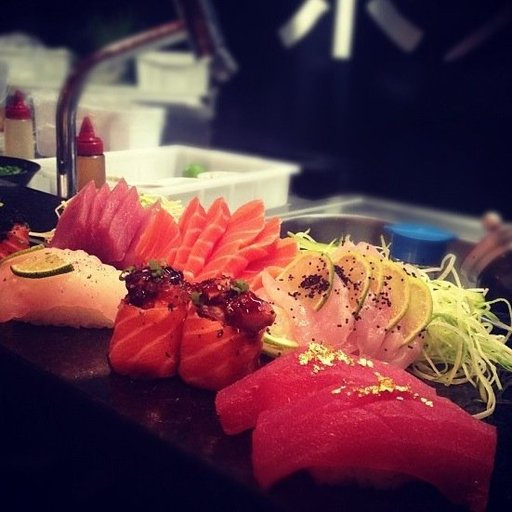

In [7]:
# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 3. Transforming data

### 3.1 Transforming data with `torchvision.transforms`

In [8]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [9]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

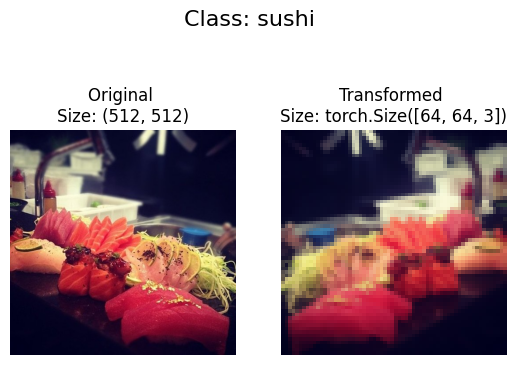

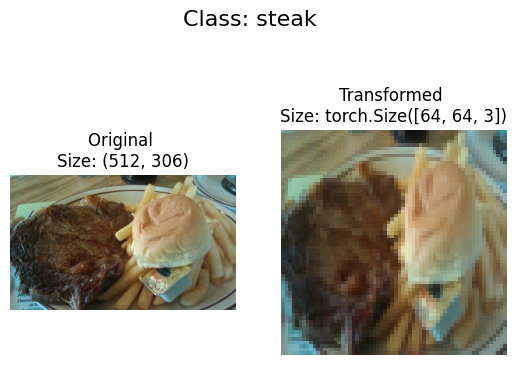

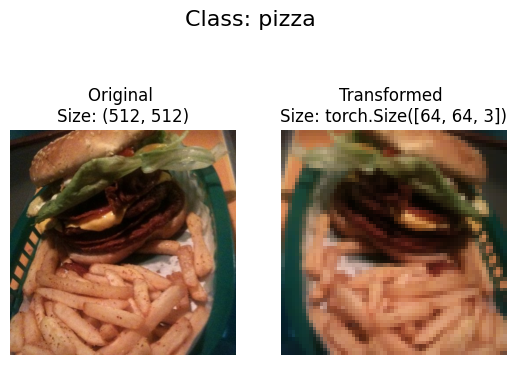

In [10]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Loading Image Data Using ImageFolder

In [11]:
# Use ImageFolder to create dataset(s)

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2250
    Root location: data\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 750
    Root location: data\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lengths
len(train_data), len(test_data)

(2250, 750)

In [15]:
img, label = train_data[0]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1765, 0.2118, 0.2471,  ..., 0.1490, 0.2392, 0.2196],
         [0.2314, 0.1490, 0.1137,  ..., 0.1804, 0.2784, 0.2549],
         [0.4353, 0.3804, 0.2275,  ..., 0.2157, 0.2549, 0.2824],
         ...,
         [0.4431, 0.3412, 0.2196,  ..., 0.2706, 0.5098, 0.5373],
         [0.4549, 0.4471, 0.3412,  ..., 0.3608, 0.5020, 0.5020],
         [0.4392, 0.4627, 0.4510,  ..., 0.4078, 0.4549, 0.4510]],

        [[0.1922, 0.2275, 0.2627,  ..., 0.1608, 0.2588, 0.2314],
         [0.2471, 0.1608, 0.1255,  ..., 0.1922, 0.2980, 0.2627],
         [0.4588, 0.4000, 0.2392,  ..., 0.2275, 0.2745, 0.2902],
         ...,
         [0.4980, 0.3765, 0.2157,  ..., 0.2745, 0.5490, 0.5843],
         [0.5137, 0.5020, 0.3725,  ..., 0.3765, 0.5373, 0.5373],
         [0.4980, 0.5176, 0.5059,  ..., 0.4275, 0.4784, 0.4745]],

        [[0.1451, 0.1804, 0.2157,  ..., 0.1098, 0.1765, 0.1490],
         [0.1922, 0.1176, 0.0980,  ..., 0.1333, 0.2078, 0.1765],
         [0.3490, 0.3059, 0.1843,  ..., 0.15

### 4.1 Show first train sample

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


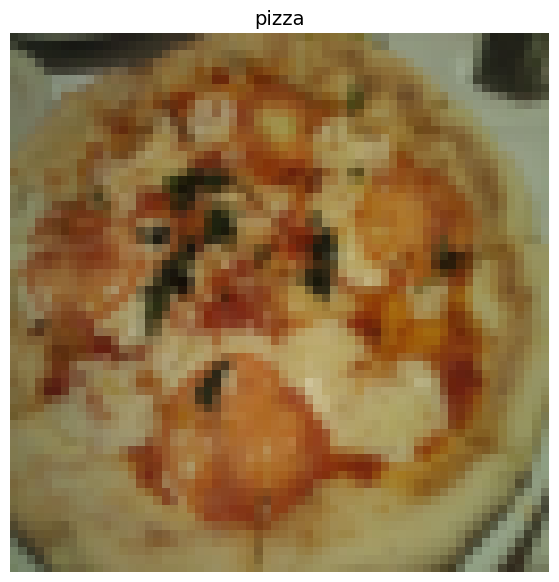

In [16]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.2 Turn loaded images into DataLoader's

In [17]:
# Turn train and test Datasets into DataLoaders

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2816e3d7110>,
 <torch.utils.data.dataloader.DataLoader at 0x2816bf44e90>)

In [18]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5. Data augmentation with `transforms.TrivialAugmentWide()`

**Data augmentation** is the process of altering your data in such a way that you artificially increase the diversity of your training set.

* `transforms.TrivialAugmentWide()` generally perform better than hand-picked transforms.
* Idea behind `transforms.TrivialAugmentWide()`: There is a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more intense).

In [19]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

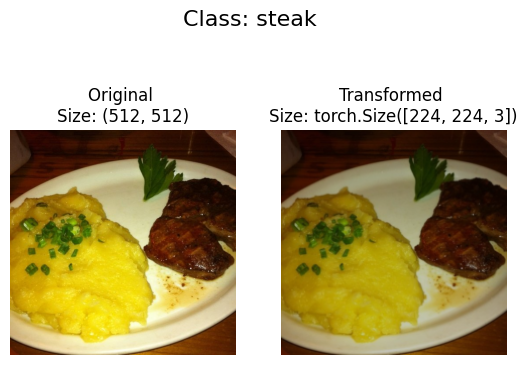

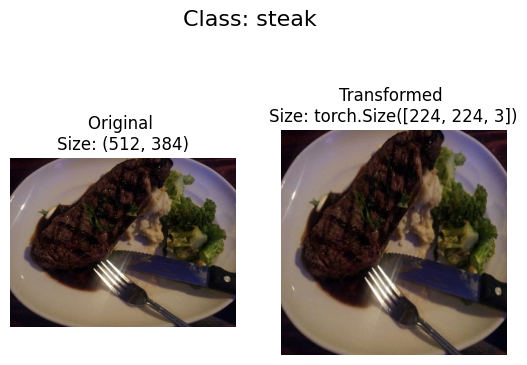

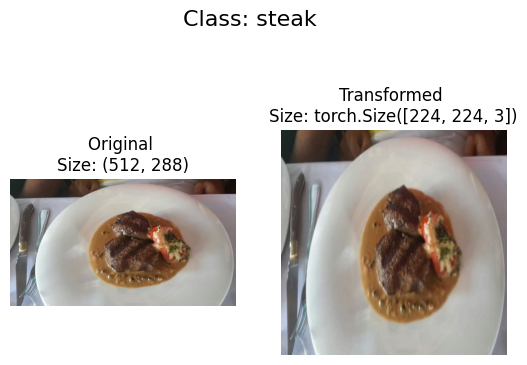

In [20]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 6. Model 0: TinyVGG without data augmentation

### Creating transforms and loading data for Model 0

In [21]:
# Create simple transform with only resizing the images
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [22]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 16 workers.


(<torch.utils.data.dataloader.DataLoader at 0x2816be160c0>,
 <torch.utils.data.dataloader.DataLoader at 0x2816bf00dd0>)

### Create TinyVGG model class

In [23]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # Each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # x = self.conv_block_2(x)
        # x = self.classifier(x)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion


In [24]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### Try a forward pass on a single image (to test the model)

In [25]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0611, 0.0662, 0.0360]])

Output prediction probabilities:
tensor([[0.3355, 0.3372, 0.3272]])

Output prediction label:
tensor([1])

Actual label:
2


### Use `torchinfo` to get an idea of the shapes going through the model

In [26]:
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### Create train & test loop functions

In [27]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [28]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Creating a `train()` function to combine `train_step()` and `test_step()`

In [29]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### Train and Evaluate Model 0

In [30]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=64,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9670 | train_acc: 0.5109 | test_loss: 0.8859 | test_acc: 0.5828
Epoch: 2 | train_loss: 0.8868 | train_acc: 0.5840 | test_loss: 0.8217 | test_acc: 0.6239
Epoch: 3 | train_loss: 0.8288 | train_acc: 0.6196 | test_loss: 0.7860 | test_acc: 0.6592
Epoch: 4 | train_loss: 0.7638 | train_acc: 0.6658 | test_loss: 0.8352 | test_acc: 0.6440
Epoch: 5 | train_loss: 0.7215 | train_acc: 0.6919 | test_loss: 0.8109 | test_acc: 0.6365
Epoch: 6 | train_loss: 0.6765 | train_acc: 0.7216 | test_loss: 0.8094 | test_acc: 0.6553
Epoch: 7 | train_loss: 0.6162 | train_acc: 0.7484 | test_loss: 0.7379 | test_acc: 0.6840
Epoch: 8 | train_loss: 0.5230 | train_acc: 0.7969 | test_loss: 0.7719 | test_acc: 0.6955
Epoch: 9 | train_loss: 0.4546 | train_acc: 0.8129 | test_loss: 0.8156 | test_acc: 0.6951
Epoch: 10 | train_loss: 0.3709 | train_acc: 0.8602 | test_loss: 0.8650 | test_acc: 0.6812
Epoch: 11 | train_loss: 0.2846 | train_acc: 0.8924 | test_loss: 1.0534 | test_acc: 0.6417
Epoch: 12 | train_l

Model decrease loss and increase accuracy!

### Plot the loss curves of Model 0

In [31]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [32]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot with custom styles
    plt.figure(figsize=(15, 7))
    plt.style.use('dark_background')

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss', color='magenta', linewidth=2)
    plt.plot(epochs, test_loss, label='Test Loss', color='lime', linewidth=2)
    plt.title('Loss over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy', color='magenta', linewidth=2)
    plt.plot(epochs, test_accuracy, label='Test Accuracy', color='lime', linewidth=2)
    plt.title('Accuracy over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()

    # Adjust layout
    plt.tight_layout()

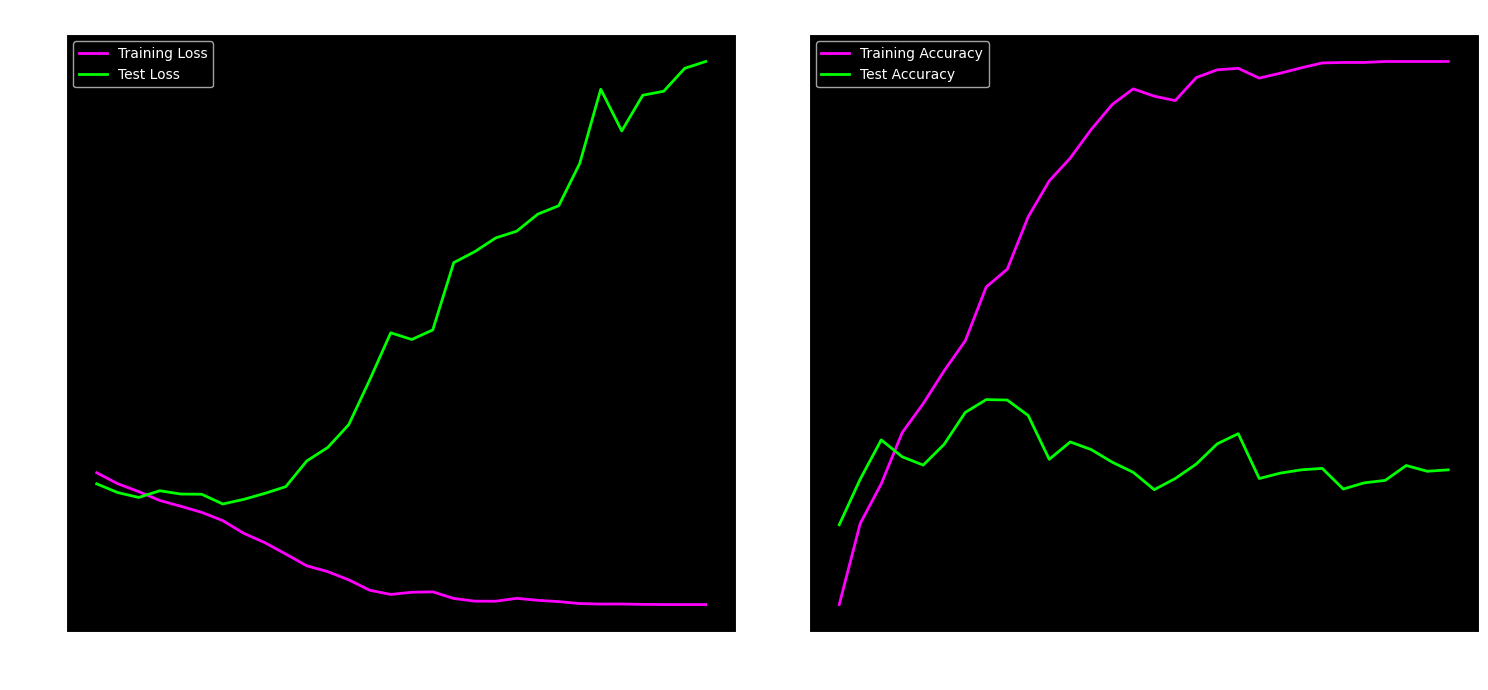

In [33]:
plot_loss_curves(model_0_results)

## Model 1: TinyVGG with Data Augmentation

### Create transform with data augmentation

In [34]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### Create train and test Datasets and DataLoaders

In [35]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 2250
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 750
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [36]:
# Turn Datasets into DataLoader's
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2816e27cc80>,
 <torch.utils.data.dataloader.DataLoader at 0x2816bf44e90>)

### Construct and train Model 1

In [37]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=64,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=3, bias=True)
  )
)

In [38]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 500

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0194 | train_acc: 0.4614 | test_loss: 0.8855 | test_acc: 0.5977
Epoch: 2 | train_loss: 0.9579 | train_acc: 0.5305 | test_loss: 0.9305 | test_acc: 0.5335
Epoch: 3 | train_loss: 0.9395 | train_acc: 0.5497 | test_loss: 0.8533 | test_acc: 0.5871
Epoch: 4 | train_loss: 0.9307 | train_acc: 0.5522 | test_loss: 0.8418 | test_acc: 0.6031
Epoch: 5 | train_loss: 0.9093 | train_acc: 0.5760 | test_loss: 0.8494 | test_acc: 0.5991
Epoch: 6 | train_loss: 0.9152 | train_acc: 0.5674 | test_loss: 0.8285 | test_acc: 0.5958
Epoch: 7 | train_loss: 0.8824 | train_acc: 0.5808 | test_loss: 0.7558 | test_acc: 0.6754
Epoch: 8 | train_loss: 0.8296 | train_acc: 0.6240 | test_loss: 0.7154 | test_acc: 0.6825
Epoch: 9 | train_loss: 0.8243 | train_acc: 0.6414 | test_loss: 0.7151 | test_acc: 0.6873
Epoch: 10 | train_loss: 0.7884 | train_acc: 0.6433 | test_loss: 0.6561 | test_acc: 0.7214
Epoch: 11 | train_loss: 0.7740 | train_acc: 0.6514 | test_loss: 0.6693 | test_acc: 0.7208
Epoch: 12 | train_l

### Plot the loss curves of Model 1

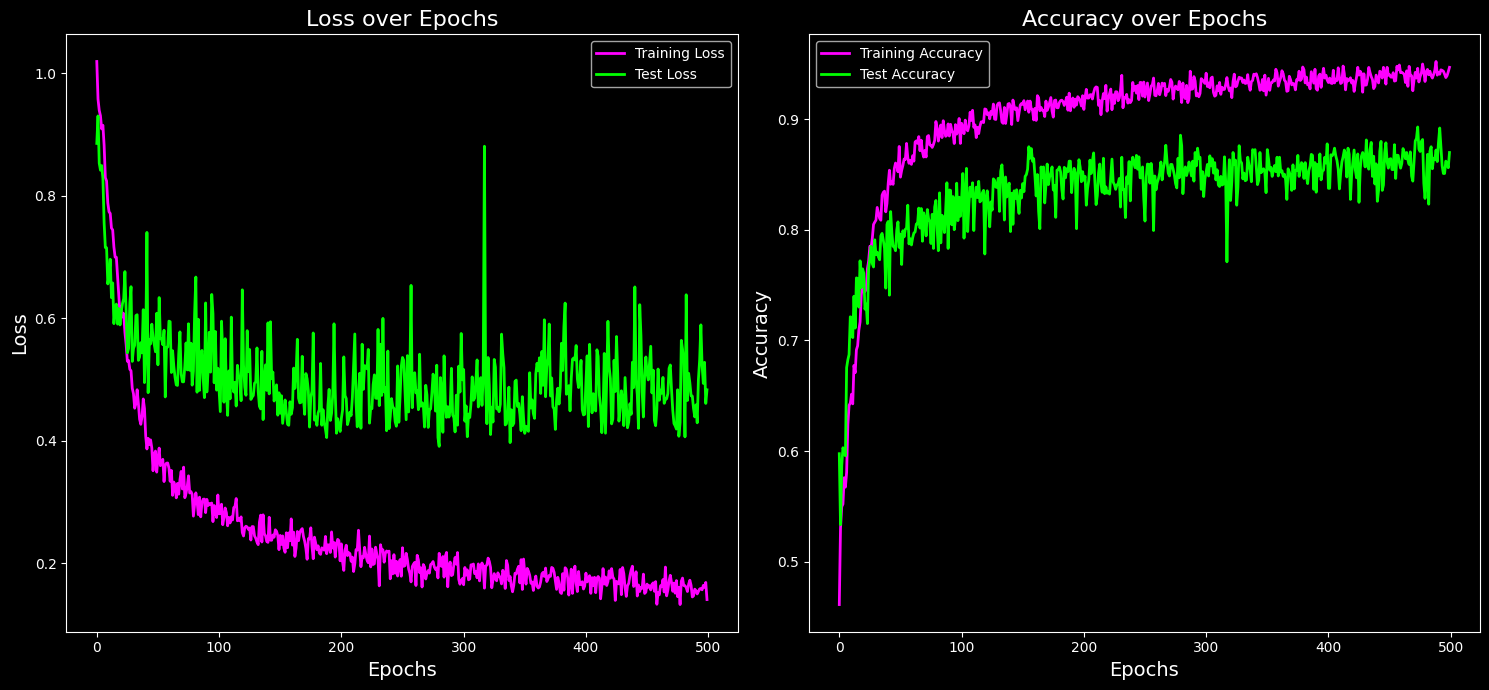

In [39]:
plot_loss_curves(model_1_results)

## Compare model results

In [40]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,0.966981,0.510915,0.885860,0.582775
1,0.886783,0.583979,0.821734,0.623884
2,0.828783,0.619630,0.786019,0.659226
3,0.763848,0.665845,0.835206,0.643973
4,0.721523,0.691901,0.810905,0.636533
5,0.676483,0.721567,0.809356,0.655320
6,0.616155,0.748415,0.737910,0.683966
7,0.523040,0.796919,0.771850,0.695499
8,0.454587,0.812940,0.815645,0.695126
9,0.370939,0.860211,0.865001,0.681176


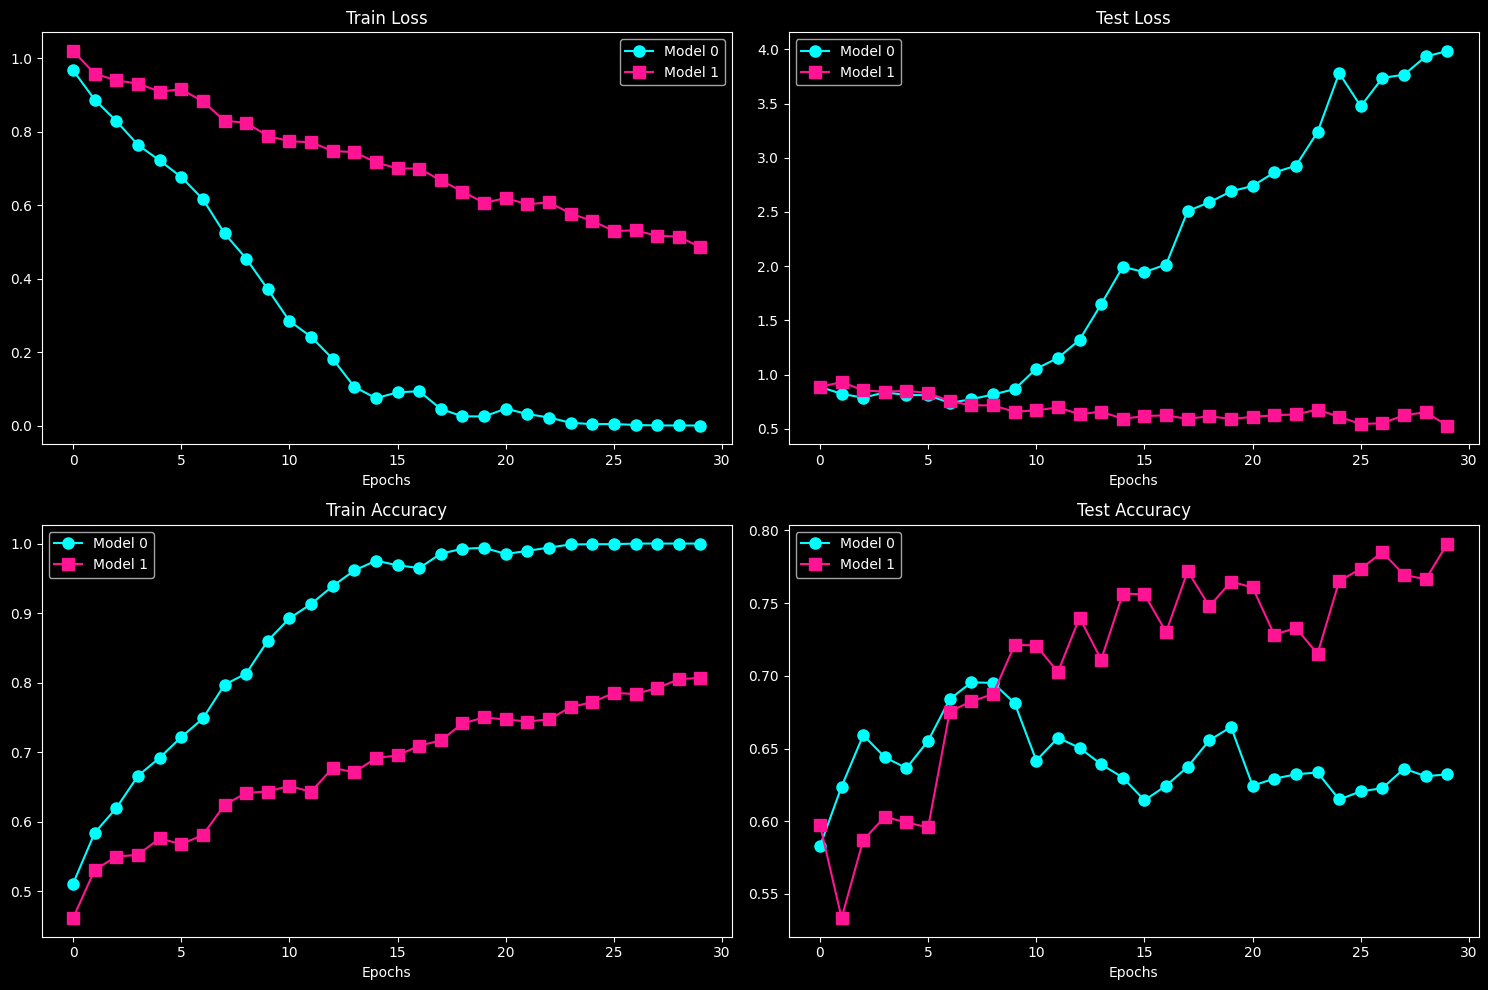

In [41]:
# Setup a plot with custom styles
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0", marker='o', markersize=8, color='cyan')
plt.plot(epochs, model_1_df["train_loss"][:30], label="Model 1", marker='s', markersize=8, color='deeppink')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0", marker='o', markersize=8, color='cyan')
plt.plot(epochs, model_1_df["test_loss"][:30], label="Model 1", marker='s', markersize=8, color='deeppink')
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0", marker='o', markersize=8, color='cyan')
plt.plot(epochs, model_1_df["train_acc"][:30], label="Model 1", marker='s', markersize=8, color='deeppink')
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0", marker='o', markersize=8, color='cyan')
plt.plot(epochs, model_1_df["test_acc"][:30], label="Model 1", marker='s', markersize=8, color='deeppink')
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Adjust layout
plt.tight_layout()


## Make a prediction on a custom image

In [42]:
custom_image_path = "./custom_test_data/pizza_test_2.jpeg"

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[227, 228, 228,  ...,  82,  82,  81],
         [228, 228, 228,  ...,  81,  81,  81],
         [229, 229, 229,  ...,  79,  80,  80],
         ...,
         [132, 126, 119,  ..., 116, 116, 116],
         [133, 126, 118,  ..., 114, 114, 114],
         [131, 123, 114,  ..., 112, 112, 112]],

        [[224, 225, 225,  ...,  86,  86,  85],
         [225, 225, 225,  ...,  85,  85,  85],
         [226, 226, 226,  ...,  83,  84,  84],
         ...,
         [124, 118, 111,  ..., 112, 112, 112],
         [125, 118, 110,  ..., 110, 110, 110],
         [123, 115, 106,  ..., 108, 108, 108]],

        [[205, 206, 206,  ...,  87,  87,  86],
         [206, 206, 206,  ...,  86,  86,  86],
         [207, 207, 207,  ...,  84,  85,  85],
         ...,
         [122, 116, 109,  ..., 101, 101, 101],
         [123, 116, 108,  ...,  99,  99,  99],
         [121, 113, 104,  ...,  97,  97,  97]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 1024, 768])

Custom image dtyp

In [43]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.8902, 0.8941, 0.8941,  ..., 0.3216, 0.3216, 0.3176],
         [0.8941, 0.8941, 0.8941,  ..., 0.3176, 0.3176, 0.3176],
         [0.8980, 0.8980, 0.8980,  ..., 0.3098, 0.3137, 0.3137],
         ...,
         [0.5176, 0.4941, 0.4667,  ..., 0.4549, 0.4549, 0.4549],
         [0.5216, 0.4941, 0.4627,  ..., 0.4471, 0.4471, 0.4471],
         [0.5137, 0.4824, 0.4471,  ..., 0.4392, 0.4392, 0.4392]],

        [[0.8784, 0.8824, 0.8824,  ..., 0.3373, 0.3373, 0.3333],
         [0.8824, 0.8824, 0.8824,  ..., 0.3333, 0.3333, 0.3333],
         [0.8863, 0.8863, 0.8863,  ..., 0.3255, 0.3294, 0.3294],
         ...,
         [0.4863, 0.4627, 0.4353,  ..., 0.4392, 0.4392, 0.4392],
         [0.4902, 0.4627, 0.4314,  ..., 0.4314, 0.4314, 0.4314],
         [0.4824, 0.4510, 0.4157,  ..., 0.4235, 0.4235, 0.4235]],

        [[0.8039, 0.8078, 0.8078,  ..., 0.3412, 0.3412, 0.3373],
         [0.8078, 0.8078, 0.8078,  ..., 0.3373, 0.3373, 0.3373],
         [0.8118, 0.8118, 0.8118,  ..

### Predicting on custom image with a trained PyTorch model

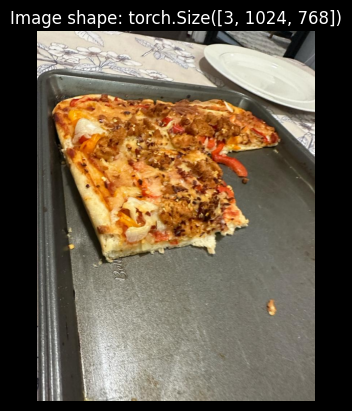

In [44]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [45]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 1024, 768])
New shape: torch.Size([3, 64, 64])


In [46]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names=None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(image_path).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

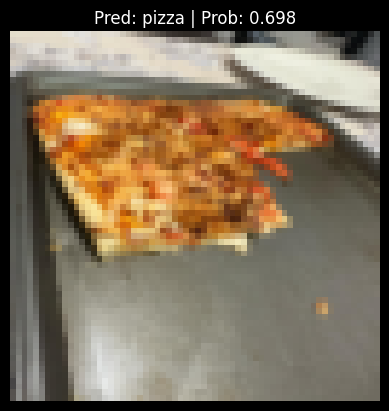

In [47]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)